# LES Band Orientation Model Training
---
Central Lake Ontario Buoy Environmental Database

### Carter J. Humphreys
Email: [chumphre@oswego.edu](mailto:chumphre@oswego.edu) | GitHub:[@HumphreysCarter](https://github.com/HumphreysCarter) | Website: [carterhumphreys.com](http://carterhumphreys.com/)

In [93]:
import pickle
import joblib 
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score 

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

## Load The Data

In [94]:
# Load dataset
dataPath="../data/LO1_dataset.csv"
dataset=pd.read_csv(dataPath)

In [95]:
# Drop unused data
dataset=dataset.drop(['DateTime [UTC]', 'BandAz_LO1 [deg]', 'BandIntensity [dBZ]', 'BandRng_LO1 [km]'], axis=1)

## Dataset Summary

In [96]:
# shape
print(dataset.shape)

(1145, 36)


In [97]:
# head
print(dataset.head(5))

   BandStart_Latitude  BandStart_Longitude  BandMidpoint_Latitude  \
0           43.535946           -76.223320              43.353896   
1           43.532036           -76.217194              43.334646   
2           43.521149           -76.232010              43.346326   
3           43.518513           -76.217072              43.339364   
4           43.565903           -76.202736              43.259891   

   BandMidpoint_Longitude  BandEnd_Latitude  BandEnd_Longitude  \
0              -75.329963         43.234745         -74.595901   
1              -75.373511         43.143089         -74.490379   
2              -75.618544         43.195889         -74.990135   
3              -75.832468         43.176296         -75.413177   
4              -75.604233         42.989628         -75.002983   

   WaterTemp_Ontario [degC]  IceCover_Ontario [%]  IceCover_Huron [%]  \
0                     13.26                   0.0                 0.0   
1                     13.26               

In [98]:
# descriptions
print(dataset.describe())

       BandStart_Latitude  BandStart_Longitude  BandMidpoint_Latitude  \
count         1145.000000          1145.000000            1145.000000   
mean            43.630653           -76.381776              43.633758   
std              0.233597             0.279259               0.348498   
min             43.243790           -77.509819              42.907711   
25%             43.446945           -76.559319              43.339364   
50%             43.617672           -76.225258              43.619020   
75%             43.780396           -76.199753              43.901171   
max             44.314522           -76.050560              44.518521   

       BandMidpoint_Longitude  BandEnd_Latitude  BandEnd_Longitude  \
count             1145.000000       1145.000000        1145.000000   
mean               -75.787178         43.639705         -75.142739   
std                  0.408128          0.519221           0.670774   
min                -77.060097         42.608696         -76.93

In [99]:
# class distribution
print(dataset.groupby(['BandStart_Latitude', 'BandStart_Longitude']).size())

BandStart_Latitude  BandStart_Longitude
43.243790           -77.509819             1
43.248756           -77.003174             1
43.253349           -77.061295             1
43.254963           -77.477936             1
43.257233           -77.469215             1
                                          ..
44.259010           -76.164742             1
44.267601           -76.164268             1
44.309586           -76.296242             1
44.310493           -76.092506             1
44.314522           -76.264351             1
Length: 1102, dtype: int64


## Data Visualization

In [100]:
# box and whisker plots
#dataset.plot(figsize=(20, 20), kind='box', subplots=True, layout=(6,6), sharex=False, sharey=False)
#pyplot.show()

In [101]:
# histograms
#dataset.hist(figsize=(20,20), layout=(6,6))
#pyplot.show()

In [102]:
# scatter plot matrix
#scatter_matrix(dataset, figsize=(20,20))
#pyplot.show()

## Algorithms

In [103]:
# Split-out validation dataset
array = dataset.values
X = array[:,6:36]
y = array[:,0:6]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.30, random_state=1)
print(y)
print(X)

[[ 43.535946   -76.22332     43.35389555 -75.329963    43.234745
  -74.595901  ]
 [ 43.532036   -76.217194    43.33464587 -75.37351127  43.143089
  -74.490379  ]
 [ 43.521149   -76.23201     43.34632558 -75.61854384  43.195889
  -74.990135  ]
 ...
 [ 43.553471   -76.185211    43.228888   -75.63504386  42.98103
  -75.192307  ]
 [ 43.320927   -76.710991    43.121541   -76.32067063  42.869659
  -75.870171  ]
 [ 43.384274   -76.656464    43.12864013 -76.4084122   42.85833
  -75.925262  ]]
[[ 13.26   0.     0.   ...  37.65 -12.4   26.86]
 [ 13.26   0.     0.   ...  36.14 -13.87  30.15]
 [ 13.26   0.     0.   ...  34.44 -13.16  28.75]
 ...
 [  2.23   4.63  19.43 ...  30.79   9.28  22.16]
 [  2.23   4.63  19.43 ...  32.32   5.9   25.14]
 [  2.23   4.63  19.43 ...  33.84   1.33  32.51]]


In [104]:
# Spot Check Algorithms
models = []
models.append(('MultiLR', LinearRegression()))
models.append(('KNN(n=2)', KNeighborsRegressor(n_neighbors=2)))
models.append(('KNN(n=5)', KNeighborsRegressor(n_neighbors=5)))
#models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
#models.append(('MLPR', MLPRegressor()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    if name != 'MultiLR': # Hide MultiLR since data is skewed 
        results.append(cv_results)
        names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

MultiLR: 0.439294 (0.035486)
KNN(n=2): 0.730177 (0.042660)
KNN(n=5): 0.649509 (0.049432)


/home/CarterHumphreys/.virtualenvs/research/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/CarterHumphreys/.virtualenvs/research/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the 

RandomForest: 0.636448 (0.041955)


/home/CarterHumphreys/.virtualenvs/research/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


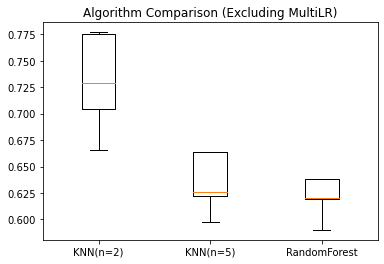

In [105]:
# Compare Algorithms
pyplot.boxplot(results, labels=names, showfliers=False)
pyplot.title('Algorithm Comparison (Excluding MultiLR)')
pyplot.show()

## Predictions and Validation

==================== MultiLR ====================


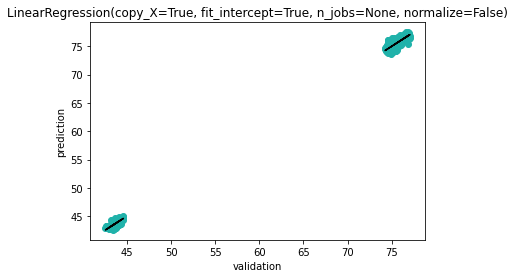

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.23557716453904473	0.23557716453904473
mean_squared_error	0.10159826658954103	0.10159826658954103
r2_score		0.4944151462317941	0.4944151462317941


==================== KNN(n=2) ====================


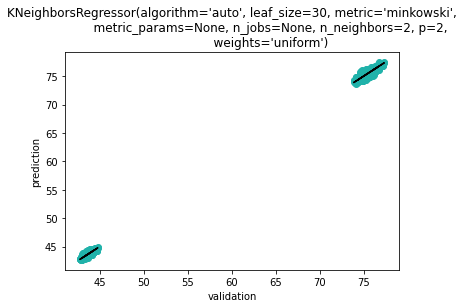

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.12803433546258147	0.12803433546258147
mean_squared_error	0.04072753828757389	0.04072753828757389
r2_score		0.7956182263584196	0.7956182263584196


==================== KNN(n=5) ====================


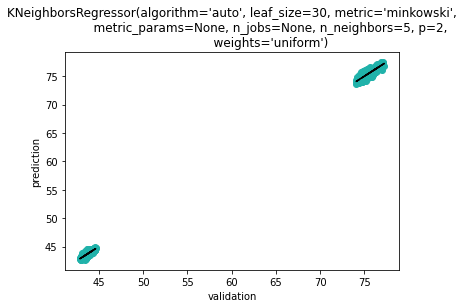

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.14997936865891015	0.14997936865891015
mean_squared_error	0.04849059244662963	0.04849059244662963
r2_score		0.7494852425557305	0.7494852425557305


==================== RandomForest ====================


/home/CarterHumphreys/.virtualenvs/research/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


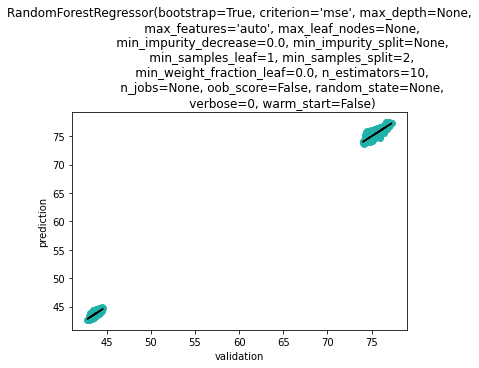

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.15786745617431186	0.15988316443604947
mean_squared_error	0.051705663725266825	0.05319830473841775
r2_score		0.7373572300882406	0.727097933031887
Saving model...




In [106]:
for name, model in models:
    print(f'==================== {name} ====================') 
    
    # Make predictions on validation dataset
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    
    # Evaluate current model
    #currMaxError=max_error(Y_validation, predictions)
    currAbsError=mean_absolute_error(Y_validation, predictions)
    currMeanSqrError=mean_squared_error(Y_validation, predictions)
    currR2score=r2_score(Y_validation, predictions)
    
    # Abs values
    x_abs=[]
    y_abs=[]
    for i in range(len(Y_validation)):
        y_abs.append(abs(Y_validation[i]))
        x_abs.append(abs(predictions[i]))
    
    pyplot.plot(x_abs, x_abs, color='black')
    pyplot.scatter(x_abs, y_abs, marker='o', color='lightseagreen');
    pyplot.title(f'{model}')
    pyplot.xlabel("validation")
    pyplot.ylabel("prediction")
    pyplot.show()   

    # Load previous model and make predictions on validation dataset
    previousModel=joblib.load(f'../models/LES_Band_Position_Model_{name}_LO1_LatLon')  
    previousModel.fit(X_train, Y_train)
    prevPredictions=previousModel.predict(X_validation)
    
    # Evaluate previous model
    #prevMaxError=max_error(Y_validation, prevPredictions)
    prevAbsError=mean_absolute_error(Y_validation, prevPredictions)
    prevMeanSqrError=mean_squared_error(Y_validation, prevPredictions)
    prevR2score=r2_score(Y_validation, prevPredictions)
    
    print('Metric\t\t\tCurr Score\t\tPrev Score')
    print('----------\t\t---------\t\t--------')
    #print(f'max_error\t\t{currMaxError}\t{prevMaxError}')
    print(f'mean_absolute_error\t{currAbsError}\t{prevAbsError}')
    print(f'mean_squared_error\t{currMeanSqrError}\t{prevMeanSqrError}')
    print(f'r2_score\t\t{currR2score}\t{prevR2score}')

    # Save model if r^2 better
    if currR2score > prevR2score:
        print('Saving model...')
        joblib.dump(model, f'../models/LES_Band_Position_Model_{name}_LO1_LatLon') 
    print('\n')